# Description:
To be done

### Imports

In [1]:
#import argparse
#from array import array
import glob
import math
import numpy as np
import os
import ROOT
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F, TH3F, TH1, TLine
#from ROOT import gROOT, gBenchmark, gRandom, gSystem, Double, gStyle
import time

Welcome to JupyROOT 6.22/02


### ROOT Batch Mode

In [2]:
# ROOT.gROOT.SetBatch(1)

### Paths

In [3]:
# ============================================================
# Set paths
# ============================================================
datapath = '/data/SingleModule_Nov2020/LArPix/dataRuns/rootTrees/combined_with_light'
print(' datapath:   ', datapath)

outputpath = '/home/lhep/PACMAN/larpix-analysis/lightCharge_anticorrelation'
print(' outputpath: ', outputpath)

files = sorted([os.path.basename(path) for path in glob.glob(datapath+'/*.root')])
print(' datafiles (', len(files), '): ')
for f in files:
    print('              ', f)

 datapath:    /data/SingleModule_Nov2020/LArPix/dataRuns/rootTrees/combined_with_light
 outputpath:  /home/lhep/PACMAN/larpix-analysis/lightCharge_anticorrelation
 datafiles ( 22 ): 
               sync_wLightReco_20201129_122204.root
               sync_wLightReco_20201129_122655.root
               sync_wLightReco_20201129_130449.root
               sync_wLightReco_20201129_134857.root
               sync_wLightReco_20201129_143427.root
               sync_wLightReco_20201129_150749.root
               sync_wLightReco_20201129_155227.root
               sync_wLightReco_20201129_162434.root
               sync_wLightReco_20201129_170918.root
               sync_wLightReco_20201129_174140.root
               sync_wLightReco_20201129_182214.root
               sync_wLightReco_20201129_185437.root
               sync_wLightReco_20201129_193550.root
               sync_wLightReco_20201129_200721.root
               sync_wLightReco_20201129_204607.root
               sync_wLightReco_202011

### Define voxelisation

In [4]:
# ============================================================
# Define voxelisation
# ============================================================
n_pixels_x = 70
n_pixels_y = 70
n_pixels_z = 70
pitch_x = 4.434
pitch_y = 4.434
pitch_z = 4.434
pixels_x_min = - pitch_x * n_pixels_x/2. #155.19
pixels_x_max =   pitch_x * n_pixels_x/2. #155.19
pixels_y_min = - pitch_y * n_pixels_y/2. #155.19
pixels_y_max =   pitch_y * n_pixels_y/2. #155.19
pixels_z_min = 0
pixels_z_max = n_pixels_z*pitch_z*10 # factor 10 for correction... TODO: CHANGE THIS FOR NEXT PRODUCTION!!
#pixels_z_min = - pitch_z * n_pixels_z/2. #155.19
#pixels_z_max =   pitch_z * n_pixels_z/2. #155.19
#pixels_y_min = -155.19
#pixels_y_max = 155.19

### Define which plots to make

In [5]:
plot_all                                      = False

plot_lightYield                               = False
plot_trackLength                              = False
plot_nHits                                    = False
plot_q_raw_tot                                = False
plot_chargeYield                              = False
plot_dQdl                                     = False
plot_startPosY_vs_startPosX                   = False
plot_endPosY_vs_endPosX                       = False
plot_startPosZ_vs_endPosZ                     = False
plot_nHits_vs_trackLength                     = False
plot_3D_graviCentre                           = False
plot_graviCentre_projection_xy                = False
plot_graviCentre_projection_xz                = False
plot_graviCentre_projection_yz                = False
plot_lightYield_vs_graviCentre_x              = True
plot_lightYield_vs_graviCentre_x_Selection    = True
plot_lightYield_vs_graviCentre_x_ProfilePlot  = True
plot_chargeYield_vs_eField                    = True
plot_chargeYield_vs_eField_ProfilePlot        = True
plot_chargeYield_vs_graviCentre_x             = True
plot_chargeYield_vs_graviCentre_x_Selection   = True
plot_chargeYield_vs_graviCentre_x_ProfilePlot = True

### Make a single TChain with input files

In [6]:
'''
#inputFileName = files[0]
inputFileName = 'sync_wLightReco_20201129_122204.root'
print(' Processing file', inputFileName)

input_tree = ROOT.TChain("t_out", "t_out")
input_tree.Add(datapath + '/' + inputFileName)
#for root_file in config["data_files"]:
#    input_tree.Add(root_file)
#input_tree.Add( "/path/to.root" )

# Turn on all branches of input tree
input_tree.SetBranchStatus("*",           1)
'''
print('Done.')

Done.


### Make List of TChains
Note: Make for every file a separate TChain.
Could substitute >1 files to a single TChain, but then it is more complicated to apply the electron lifetime correction...

In [7]:
#inputFileName = files[20]
#inputFileName = 'sync_wLightReco_20201129_122204.root'
#print(' Processing file', inputFileName)

input_tree_list       = []
eField_intensity_list = [] # [kV/cm]

'''
for i in range(10):
    input_tree = ROOT.TChain("t_out", "t_out")
    
    if i == 0: # 0.1 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201130_002722.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201130_005847.root')
        eField_intensity_list.append(0.1)
    if i == 1: # 0.2 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_230700.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_234000.root')
        eField_intensity_list.append(0.2)
    if i == 2: # 0.3 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_215550.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_222751.root')
        eField_intensity_list.append(0.3)
    if i == 3: # 0.4 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_204607.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_211819.root')
        eField_intensity_list.append(0.4)
    if i == 4: # 0.5 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_193550.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_200721.root')
        eField_intensity_list.append(0.5)
    if i == 5: # 0.6 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_182214.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_185437.root')
        eField_intensity_list.append(0.6)
    if i == 6: # 0.7 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_170918.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_174140.root')
        eField_intensity_list.append(0.7)
    if i == 7: # 0.8 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_155227.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_162434.root')
        eField_intensity_list.append(0.8)
    if i == 8: # 0.9 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_143427.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_150749.root')
        eField_intensity_list.append(0.9)
    if i == 9: # 1.0 kV/cm
        input_tree.Add(datapath + '/sync_wLightReco_20201129_122204.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_122655.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_130449.root')
        input_tree.Add(datapath + '/sync_wLightReco_20201129_134857.root')
        eField_intensity_list.append(1.0)
    
    # Turn on all branches of input tree
    input_tree.SetBranchStatus("*",           1)
    
    # Append input_tree TChain to the input_tree_list
    input_tree_list.append(input_tree)
'''

for i in range(len(files)):
    input_tree = ROOT.TChain("t_out", "t_out")
    #print(' files[',i,']: ', files[i])
    
    if files[i] == 'sync_wLightReco_20201130_002722.root' or\
       files[i] == 'sync_wLightReco_20201130_005847.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.1)
    if files[i] == 'sync_wLightReco_20201129_230700.root' or\
       files[i] == 'sync_wLightReco_20201129_234000.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.2)
    if files[i] == 'sync_wLightReco_20201129_215550.root' or\
       files[i] == 'sync_wLightReco_20201129_222751.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.3)
    if files[i] == 'sync_wLightReco_20201129_204607.root' or\
       files[i] == 'sync_wLightReco_20201129_211819.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.4)
    if files[i] == 'sync_wLightReco_20201129_193550.root' or\
       files[i] == 'sync_wLightReco_20201129_200721.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.5)
    if files[i] == 'sync_wLightReco_20201129_182214.root' or\
       files[i] == 'sync_wLightReco_20201129_185437.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.6)
    if files[i] == 'sync_wLightReco_20201129_170918.root' or\
       files[i] == 'sync_wLightReco_20201129_174140.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.7)
    if files[i] == 'sync_wLightReco_20201129_155227.root' or\
       files[i] == 'sync_wLightReco_20201129_162434.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.8)
    if files[i] == 'sync_wLightReco_20201129_143427.root' or\
       files[i] == 'sync_wLightReco_20201129_150749.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.9)
    if files[i] == 'sync_wLightReco_20201129_122204.root' or\
       files[i] == 'sync_wLightReco_20201129_122655.root' or\
       files[i] == 'sync_wLightReco_20201129_130449.root' or\
       files[i] == 'sync_wLightReco_20201129_134857.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(1.0)
    
    # Turn on all branches of input tree
    input_tree.SetBranchStatus("*",           1)
    
    # Append input_tree TChain to the input_tree_list
    input_tree_list.append(input_tree)
    
n_field_intensities = len(np.unique(eField_intensity_list))
print('Number of different field intensities: ', n_field_intensities)
    
print('List with input trees: ')
for i in range(len(input_tree_list)):
    print('   ', eField_intensity_list[i], 'kV/cm: \t [', input_tree_list[i], '] \t (', input_tree_list[i].GetEntries(), 'entries )')
    
print('Done.')

Number of different field intensities:  10
List with input trees: 
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 1807 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19770 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19234 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19520 entries )
    0.9 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19657 entries )
    0.9 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19369 entries )
    0.8 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19261 entries )
    0.8 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18800 entries )
    0.7 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19185 entries )
    0.7 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18178 entries )
    0.6 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18720 entries )
    0.6 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18202 entries )
    0.5 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18086 entries )
    0.5 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18149 entries )
    0.4 kV

### Create directories for plots

In [8]:
'''
# If make_plots: Create corresponding folder
make_plots = True

if make_plots:
    plot_folder = inputFileName[16:-5]
    os.system('rm -rf plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder) + '/eventDisplays')
'''
for i in range(len(eField_intensity_list)):
    plot_folder = str(eField_intensity_list[i]) + '_kV_per_cm'
    os.system('rm -rf plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder) + '/eventDisplays')
print('Done.')

Done.


### Define track selection cuts

In [9]:
# Define Selection Cuts
cut_ntracks      = 1    # Only consider events with number of reconstructed tracks == cut_ntracks
cut_lenght       = 250. # Track minimum length [mm]
cut_throughgoing = 130. # |max(track_start_y,track_end_y)| and |min(track_start_y,track_end_y)| must be greater than cut_throughgoing [mm]
#cut_nhits        = 50.  # Min. number of hits in the track [-]
#cut_residual2    = 3.   # Maximum allowed sqrt(res_x**2+res_y**2+res_z**2), in order to only allow tracks which are 'track-like' with a small spread

#TODO:
# CUT ON ANGLE (THETA?) -> THETA? MUST BE CLOSE TO ZERO IN ORDER TO HAVE ALMOST VERTICAL TRACKS

### Define electron drift velocities and lifetimes for every TChain

In [10]:
# Make a list with electron lifetimes
eDrift_vel = [] # drift velocities [mm/us]
eLifetimes = [] # one float for every TChain. Lifetime in [ms]

for chain in range(len(input_tree_list)):
    if   eField_intensity_list[chain] == 0.1: eDrift_vel.append(0.535)
    elif eField_intensity_list[chain] == 0.2: eDrift_vel.append(0.933)
    elif eField_intensity_list[chain] == 0.3: eDrift_vel.append(1.230)
    elif eField_intensity_list[chain] == 0.4: eDrift_vel.append(1.461)
    elif eField_intensity_list[chain] == 0.5: eDrift_vel.append(1.648)
    elif eField_intensity_list[chain] == 0.6: eDrift_vel.append(1.806)
    elif eField_intensity_list[chain] == 0.7: eDrift_vel.append(1.941)
    elif eField_intensity_list[chain] == 0.8: eDrift_vel.append(2.060)
    elif eField_intensity_list[chain] == 0.9: eDrift_vel.append(2.166)
    elif eField_intensity_list[chain] == 1.0: eDrift_vel.append(2.261)
    else:
        print(' WARNING: No eDrift velocity defined for eField intensity =', eField_intensity_list[chain], 'kV/cm ...')
        eDrift_vel.append(9999.9)

    eLifetimes.append(2.0) # TODO: Put here the proper lifetimes!
    
print('File summary: ')
for i in range(len(input_tree_list)):
    print('    file', i, ':\t', files[i],\
          '\t E-field: ', eField_intensity_list[i],\
          'kV/cm \t eLifetime: ', eLifetimes[i],\
          'ms \t eDrift: ', eDrift_vel[i], 'mm/us')
    
print('Done.')

File summary: 
    file 0 :	 sync_wLightReco_20201129_122204.root 	 E-field:  1.0 kV/cm 	 eLifetime:  2.0 ms 	 eDrift:  2.261 mm/us
    file 1 :	 sync_wLightReco_20201129_122655.root 	 E-field:  1.0 kV/cm 	 eLifetime:  2.0 ms 	 eDrift:  2.261 mm/us
    file 2 :	 sync_wLightReco_20201129_130449.root 	 E-field:  1.0 kV/cm 	 eLifetime:  2.0 ms 	 eDrift:  2.261 mm/us
    file 3 :	 sync_wLightReco_20201129_134857.root 	 E-field:  1.0 kV/cm 	 eLifetime:  2.0 ms 	 eDrift:  2.261 mm/us
    file 4 :	 sync_wLightReco_20201129_143427.root 	 E-field:  0.9 kV/cm 	 eLifetime:  2.0 ms 	 eDrift:  2.166 mm/us
    file 5 :	 sync_wLightReco_20201129_150749.root 	 E-field:  0.9 kV/cm 	 eLifetime:  2.0 ms 	 eDrift:  2.166 mm/us
    file 6 :	 sync_wLightReco_20201129_155227.root 	 E-field:  0.8 kV/cm 	 eLifetime:  2.0 ms 	 eDrift:  2.06 mm/us
    file 7 :	 sync_wLightReco_20201129_162434.root 	 E-field:  0.8 kV/cm 	 eLifetime:  2.0 ms 	 eDrift:  2.06 mm/us
    file 8 :	 sync_wLightReco_20201129_170918.root 

### Loop over all TChains in input_tree_list

In [11]:
e_field_list            = []
track_length_list       = []
track_n_hits_list       = []
track_start_pos_x_list  = []
track_start_pos_y_list  = []
track_start_pos_z_list  = []
track_end_pos_x_list    = []
track_end_pos_y_list    = []
track_end_pos_z_list    = []
LCM_lightYield_list     = []
track_q_raw_tot_list    = []
pixels_chargeYield_list = [] # containing n (=number of E-field intensities) lists with m (=number of gravicentres) lists
track_cgx_list          = []
track_cgy_list          = []
track_cgz_list          = []

start = time.time()
for eField in range(n_field_intensities):
    field_intensity = (eField+1)/10.
    
    #if not (field_intensity == 0.5 or field_intensity == 0.6):
    #    continue
    
    print( ' ----------------------------------------------------------------------------------- ')
    print(' Processing chains with field_intensity: ', field_intensity, 'kV/cm')
    
    # Define lists with interesting quantities
    track_length         = [] # Reconstructed track's length [mm]
    track_n_hits         = [] # Reconstructed track's total number of hits [-]
    track_start_pos_x    = [] # Reconstructed track's start position coordinates x [mm]
    track_start_pos_y    = [] # Reconstructed track's start position coordinates y [mm]
    track_start_pos_z    = [] # Reconstructed track's start position coordinates z [mm]
    track_end_pos_x      = [] # Reconstructed track's end position coordinates x [mm]
    track_end_pos_y      = [] # Reconstructed track's end position coordinates y [mm]
    track_end_pos_z      = [] # Reconstructed track's end position coordinates z [mm]
    LCM_lightYield       = [] # Total reconstructed light yield of LCM [units?] # TODO: which units?
    track_q_raw_tot      = [] # Reconstructed track's total charge deposit [ke] (no eLifetime correction)
    pixels_chargeYield   = [] # Reconstructed charge on pixels for every GC bin [ke] (eLifetime corrected)
    pix_tile_chargeYield = [] # Reconstructed charge on entire pixel tile [ke] (eLifetime corrected)
    track_cgx            = [] # gravicentre of the track (weighted by hits_q, but NOT YET ELECTRON LIFETIME CORRECTED -> TODO)
    track_cgy            = [] # gravicentre of the track (weighted by hits_q, but NOT YET ELECTRON LIFETIME CORRECTED -> TODO)
    track_cgz            = [] # gravicentre of the track (weighted by hits_q, but NOT YET ELECTRON LIFETIME CORRECTED -> TODO)
    
    for chain in range(len(input_tree_list)):
        
        # Skip the first two files (in order to have ~ the same statistics for all eField intensities):
        if chain == 0 or chain == 1:
            continue
        
        if eField_intensity_list[chain] != field_intensity:
            continue
        print('     Chain Nr.', chain)
        print('         eField [kV/cm]:     ', eField_intensity_list[chain])
        print('         eLifetime [ms]:     ', eLifetimes[chain])
        print('         eDrift_vel [mm/us]: ', eDrift_vel[chain])

        # Number of tracks in the TChain
        n_tracks = input_tree_list[chain].GetEntries()
        print('         Number of tracks : ', n_tracks)

        #print(input_tree_list[chain].Print())

        # List for events with a low light yield
        #low_light_events = []

        # List for track selection
        #selected_trackIDs = []

        # Loop over all tracks in input_tree
        for track_id in range(n_tracks):
            if(track_id%5000==0):
                now = time.time()
                print('             Processed', track_id, 'of', n_tracks, 'tracks. \t Elapsed time:', math.ceil(now-start), ' seconds ... \r')
                
            input_tree_list[chain].GetEntry(track_id)

            # Apply Selection Cuts
            if input_tree_list[chain].t_track_length < cut_lenght:
                continue
            if input_tree_list[chain].t_event_ntracks > cut_ntracks:
                continue
            if abs(max(input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_end_pos_y)) < cut_throughgoing or\
               abs(min(input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_end_pos_y)) < cut_throughgoing:
                #print(input_tree_list[chain].t_track_start_pos_y)
                #print(input_tree_list[chain].t_track_end_pos_y)
                #print(' ---------------- ')
                continue

            #if track_id > 200:
            #    break

            #selected_trackIDs.append(input_tree_list[chain].t_trackID)

            #if track_id > 15:
            #    break

            '''        
            print(' ----------------------------------------- ')
            #print(' t_eventID:           ', input_tree_list[chain].t_eventID)
            print(' t_trackID:           ', input_tree_list[chain].t_trackID)
            #print(' t_event_q:           ', input_tree_list[chain].t_event_q)
            print(' t_track_length:      ', input_tree_list[chain].t_track_length)
            print(' t_event_ntracks:     ', input_tree_list[chain].t_event_ntracks)
            print(' t_track_start_pos_y: ', input_tree_list[chain].t_track_start_pos_y)
            print(' t_track_end_pos_y:   ', input_tree_list[chain].t_track_end_pos_y)
            #print(' t_track_q:           ', input_tree_list[chain].t_track_q)
            #print(' t_event_nhits:       ', input_tree_list[chain].t_event_nhits)
            #print(' t_track_nhits:       ', input_tree_list[chain].t_track_nhits)
            #print(' t_tlcm1_tot:         ', input_tree_list[chain].l_tlcm1_tot)
            '''

            track_length.append(input_tree_list[chain].t_track_length)
            track_n_hits.append(input_tree_list[chain].t_track_nhits)
            #track_q_tot.append(input_tree_list[chain].t_track_q) # this needs to be corrected by the electron lifetime (see below)

            track_start_pos_x.append(input_tree_list[chain].t_track_start_pos_x)
            track_start_pos_y.append(input_tree_list[chain].t_track_start_pos_y)
            track_start_pos_z.append(input_tree_list[chain].t_track_start_pos_z)
            track_end_pos_x.append(input_tree_list[chain].t_track_end_pos_x)
            track_end_pos_y.append(input_tree_list[chain].t_track_end_pos_y)
            track_end_pos_z.append(input_tree_list[chain].t_track_end_pos_z)

            LCM_lightYield.append(input_tree_list[chain].l_tlcm1_tot)
            
            # For low light events
            #if input_tree_list[chain].l_tlcm1_tot<150:
            #    low_light_events.append(input_tree_list[chain].t_trackID)

            # Obtain the track's total charge and its center of gravity (weighted by deposited charge) #TODO: Correct for the electron lifetime!!!
            # Loop over all hits
            q_raw_tot  = 0.
            q_corr_tot = 0.
            cgx        = 0.
            cgy        = 0.
            cgz        = 0.
            z_min = 99999.  # TODO: In order to test z coordinates (factors of 10) # TODO: delete this variable this factor 10 problem is solved
            z_max = -99999. # TODO: In order to test z coordinates (factors of 10) # TODO: delete this variable this factor 10 problem is solved
            for hit in range(input_tree_list[chain].t_track_nhits):
                q_corr_factor = np.exp(0.1*input_tree_list[chain].t_track_hits_z[hit]/(eDrift_vel[chain]*eLifetimes[chain]*1000.)) # TODO: factor 0.1 due to factor 10 problem -> fix it
                if input_tree_list[chain].t_track_hits_z[hit] < z_min:
                    z_min = input_tree_list[chain].t_track_hits_z[hit]
                if input_tree_list[chain].t_track_hits_z[hit] > z_max:
                    z_max = input_tree_list[chain].t_track_hits_z[hit]
                #    print(' hit_z [mm]:    ', 0.1 * input_tree_list[chain].t_track_hits_z[hit]) # TODO: factor 0.1 due to factor 10 problem -> fix it
                #    print(' q_corr_factor: ', q_corr_factor)
                q_raw_tot += input_tree_list[chain].t_track_hits_q[hit]
                hit_q_corr = input_tree_list[chain].t_track_hits_q[hit] * q_corr_factor # q_corr_factor corrects for the electron lifetime
                q_corr_tot += hit_q_corr
                cgx += input_tree_list[chain].t_track_hits_x[hit]*hit_q_corr
                cgy += input_tree_list[chain].t_track_hits_y[hit]*hit_q_corr
                cgz += 0.1 * input_tree_list[chain].t_track_hits_z[hit]*hit_q_corr # TODO: factor 0.1 due to factor 10 problem -> fix it
            track_q_raw_tot.append(q_raw_tot)
            pixels_chargeYield.append(q_corr_tot)
            #print('z_min: ', z_min) # TODO: delete this variable the factor 10 problem is solved
            #print('z_max: ', z_max) # TODO: delete this variable the factor 10 problem is solved
            # normalize gravicentre
            gravicentre_x = cgx/(q_corr_tot)
            gravicentre_y = cgy/(q_corr_tot)
            gravicentre_z = cgz/(q_corr_tot)
            track_cgx.append(gravicentre_x)
            track_cgy.append(gravicentre_y)
            track_cgz.append(gravicentre_z)
            #print(' ------------------------------ ')
            #print(' t_trackID:     ', input_tree_list[chain].t_trackID)
            #print(' cgx:           ', gravicentre_x)
            #print(' cgy:           ', gravicentre_y)
            #print(' cgz:           ', gravicentre_z)
            #print(' pixels_chargeYield:   ', pixels_chargeYield[-1])

    e_field_list.append(field_intensity)
    track_length_list.append(track_length)
    track_n_hits_list.append(track_n_hits)
    track_q_raw_tot_list.append(track_q_raw_tot)
    track_start_pos_x_list.append(track_start_pos_x)
    track_start_pos_y_list.append(track_start_pos_y)
    track_start_pos_z_list.append(track_start_pos_z)
    track_end_pos_x_list.append(track_end_pos_x)
    track_end_pos_y_list.append(track_end_pos_y)
    track_end_pos_z_list.append(track_end_pos_z)
    LCM_lightYield_list.append(LCM_lightYield)
    pixels_chargeYield_list.append(pixels_chargeYield)
    track_cgx_list.append(track_cgx)
    track_cgy_list.append(track_cgy)
    track_cgz_list.append(track_cgz)
    
    #print(' Number of selected tracks: ', len(selected_trackIDs))

print(' Done.')

 ----------------------------------------------------------------------------------- 
 Processing chains with field_intensity:  0.1 kV/cm
     Chain Nr. 20
         eField [kV/cm]:      0.1
         eLifetime [ms]:      2.0
         eDrift_vel [mm/us]:  0.535
         Number of tracks :  2068
             Processed 0 of 2068 tracks. 	 Elapsed time: 0.0017244815826416016  seconds ... 
     Chain Nr. 21
         eField [kV/cm]:      0.1
         eLifetime [ms]:      2.0
         eDrift_vel [mm/us]:  0.535
         Number of tracks :  1964
             Processed 0 of 1964 tracks. 	 Elapsed time: 0.12468123435974121  seconds ... 
 ----------------------------------------------------------------------------------- 
 Processing chains with field_intensity:  0.2 kV/cm
     Chain Nr. 18
         eField [kV/cm]:      0.2
         eLifetime [ms]:      2.0
         eDrift_vel [mm/us]:  0.933
         Number of tracks :  7770
             Processed 0 of 7770 tracks. 	 Elapsed time: 0.2368545532226

### Make Plots for Selected (!) Events

In [12]:
from plot_functions import *

In [13]:
# LCM_lightYield
if plot_all or plot_lightYield:
    for eField_index in range(n_field_intensities):
        #print(LCM_lightYield_list[eField_index])
        if len(LCM_lightYield_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = np.min(LCM_lightYield_list[eField_index])
        x_max  = np.max(LCM_lightYield_list[eField_index])
        n_bins = 50
        axis_labels = ['Reconstructed LCM Light Yield [-]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_LCM_lightYield.png'
        plot_h1(LCM_lightYield_list[eField],x_min,x_max,n_bins,axis_labels,save_name)
print('Done.')

Done.


In [14]:
# Track Length
if plot_all or plot_trackLength:
    for eField_index in range(n_field_intensities):
        #print(track_length_list[eField_index])
        if len(track_length_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        x_max  = np.max(track_length_list[eField_index])
        n_bins = 50
        axis_labels = ['Track Length [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_lengths.png'
        plot_h1(track_length_list[eField_index],x_min,x_max,n_bins,axis_labels,save_name)
print('Done.')

Done.


In [15]:
# Track n_hits
if plot_all or plot_nHits:
    for eField_index in range(n_field_intensities):
        #print(track_n_hits_list[eField_index])
        if len(track_n_hits_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        x_max  = np.max(track_n_hits_list[eField_index])
        n_bins = 50
        axis_labels = ['Number of Hits [-]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_nhits.png'
        plot_h1(track_n_hits_list[eField_index],x_min,x_max,n_bins,axis_labels,save_name)
print('Done.')

Done.


In [16]:
# Track q_raw_tot
if plot_all or plot_q_raw_tot:
    for eField_index in range(n_field_intensities):
        #print(track_q_raw_tot_list[eField_index])
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        x_max  = np.max(track_q_raw_tot_list[eField_index])
        n_bins = 50
        axis_labels = ['Total Deposited Charge [ke]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_q_raw_tot.png'
        plot_h1(track_q_raw_tot_list[eField_index],x_min,x_max,n_bins,axis_labels,save_name)
print('Done.')

Done.


In [17]:
# Track chargeYield (eLifetime corrected)
if plot_all or plot_chargeYield:
    for eField_index in range(n_field_intensities):
        #print(pixels_chargeYield_list[eField_index])
        if len(pixels_chargeYield_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        x_max  = np.max(pixels_chargeYield_list[eField_index])
        n_bins = 50
        axis_labels = ['Total Deposited Charge [ke]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_chargeYield.png'
        plot_h1(pixels_chargeYield_list[eField_index],x_min,x_max,n_bins,axis_labels,save_name)
print('Done.')

Done.


In [18]:
# Track dQ/dl (eLifetime corrected)
if plot_all or plot_dQdl:
    for eField_index in range(n_field_intensities):
        #print(pixels_chargeYield_list[eField_index])
        if len(pixels_chargeYield_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min  = 0
        #x_max  = np.max(np.array(track_q_raw_tot_list[eField_index])/np.array(track_length_list[eField_index]))
        x_max  = np.max(np.array(pixels_chargeYield_list[eField_index])/np.array(track_length_list[eField_index]))
        n_bins = 50
        axis_labels = ['<dQ/dl> [ke/mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h1_track_dQ_dl_2.png'
        #plot_h1(np.array(track_q_raw_tot_list[eField_index])/np.array(track_length_list[eField_index]),x_min,x_max,n_bins,axis_labels,save_name)
        plot_h1(np.array(pixels_chargeYield_list[eField_index])/np.array(track_length_list[eField_index]),x_min,x_max,n_bins,axis_labels,save_name)
print('Done.')

Done.


In [19]:
# start_pos_y vs. start_pos_x
if plot_all or plot_startPosY_vs_startPosX:
    for eField_index in range(n_field_intensities):
        #print(track_start_pos_x_list[eField_index])
        if len(track_start_pos_x_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min # np.min(track_start_pos_x_list[eField_index])
        x_max    = pixels_x_max # np.max(track_start_pos_x_list[eField_index])
        y_min    = pixels_y_min # np.min(track_start_pos_y_list[eField_index])
        y_max    = pixels_y_max # np.max(track_start_pos_y_list[eField_index])
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track Start Position x [mm]','Track Start Position y [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_track_startPos.png'
        plot_h2([track_start_pos_x_list[eField_index],track_start_pos_y_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
print('Done.')

Done.


In [20]:
# end_pos_y vs. end_pos_x
if plot_all or plot_endPosY_vs_endPosX:
    for eField_index in range(n_field_intensities):
        #print(track_end_pos_x_list[eField_index])
        if len(track_end_pos_x_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min # np.min(track_start_pos_x_list[eField_index])
        x_max    = pixels_x_max # np.max(track_start_pos_x_list[eField_index])
        y_min    = pixels_y_min # np.min(track_start_pos_y_list[eField_index])
        y_max    = pixels_y_max # np.max(track_start_pos_y_list[eField_index])
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track End Position x [mm]','Track End Position y [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_track_endPos.png'
        plot_h2([track_end_pos_x_list[eField_index],track_end_pos_y_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
print('Done.')

Done.


In [21]:
# start_pos_z vs. end_pos_z
if plot_all or plot_startPosZ_vs_endPosZ:
    for eField_index in range(n_field_intensities):
        #print(track_start_pos_x_list[eField_index])
        if len(track_start_pos_z_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        z_start_min = np.min(track_start_pos_z_list[eField_index])
        z_start_max = np.max(track_start_pos_z_list[eField_index])
        z_end_min   = np.min(track_end_pos_z_list[eField_index])
        z_end_max   = np.max(track_end_pos_z_list[eField_index])
        n_bins = n_pixels_z
        x_bins = np.linspace(z_start_min,z_start_max,n_bins)
        y_bins = np.linspace(z_end_min,z_end_max,n_bins)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track Start Position z [mm]','Track End Position z [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_trEndz_vs_trStartz.png'
        plot_h2([track_start_pos_z_list[eField_index],track_end_pos_z_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
print('Done.')

Done.


In [22]:
# NHits vs. TrackLength
if plot_all or plot_nHits_vs_trackLength:
    for eField_index in range(n_field_intensities):
        #print(track_length_list[eField_index])
        if len(track_length_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = 0
        x_max    = 500
        y_min    = 0
        y_max    = 200
        n_bins_x = 50
        n_bins_y = 50
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Track Length [mm]','Number of Hits [-]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_trackLength_vs_trackNHits.png'
        plot_h2([track_length_list[eField_index],track_n_hits_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
print('Done.')

Done.


In [23]:
# 3D plot of gravicentres
if plot_all or plot_3D_graviCentre:
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        if len(track_cgx_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = pixels_y_min
        y_max    = pixels_y_max
        z_min    = 0
        z_max    = max(pixels_z_max,np.max(track_cgz_list[eField_index]))
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        n_bins_z = n_pixels_z
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        z_bins = np.linspace(z_min,z_max,n_bins_z)
        save_name = 'plots/'+str(plot_folder)+'/'+'h3_graviCentre.png'
        plot_h3_unweighted([track_cgx_list[eField_index],track_cgy_list[eField_index],track_cgz_list[eField_index]],\
                           x_bins,y_bins,z_bins,['Coordinate x [mm]','Coordinate y [mm]','Coordinate z [mm]'],save_name)
print('Done.')

Done.


In [24]:
# Gravycentre projection onto xy plane
if plot_all or plot_graviCentre_projection_xy:
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        if len(track_cgx_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = pixels_y_min
        y_max    = pixels_y_max
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Coordinate x [mm]','Coordinate y [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_graviCentre_xy.png'
        plot_h2([track_cgx_list[eField_index],track_cgy_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
print('Done.')

Done.


In [25]:
# Gravycentre projection onto xz plane
if plot_all or plot_graviCentre_projection_xz:
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        if len(track_cgx_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        z_min    = 0
        z_max    = max(pixels_z_max,np.max(track_cgz_list[eField_index]))
        n_bins_x = n_pixels_x
        n_bins_z = n_pixels_z
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        z_bins = np.linspace(z_min,z_max,n_bins_z)
        #x_bins = np.arange(x_min,x_max+1,step=1.)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        axis_labels = ['Coordinate x [mm]','Coordinate z [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_graviCentre_xz.png'
        plot_h2([track_cgx_list[eField_index],track_cgz_list[eField_index]],x_bins,z_bins,axis_labels,save_name)
print('Done.')

Done.


In [26]:
# Gravycentre projection onto yz plane
if plot_all or plot_graviCentre_projection_yz:
    for eField_index in range(n_field_intensities):
        #print(track_cgy_list[eField_index])
        if len(track_cgy_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        y_min    = pixels_y_min
        y_max    = pixels_y_max
        z_min    = 0
        z_max    = max(pixels_z_max,np.max(track_cgz_list[eField_index]))
        n_bins_y = n_pixels_y
        n_bins_z = n_pixels_z
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        z_bins = np.linspace(z_min,z_max,n_bins_z)
        #y_bins = np.arange(y_min,y_max+1,step=1.)
        #z_bins = np.arange(z_min,z_max+1,step=1.)
        axis_labels = ['Coordinate y [mm]','Coordinate z [mm]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_graviCentre_yz.png'
        plot_h2([track_cgy_list[eField_index],track_cgz_list[eField_index]],y_bins,z_bins,axis_labels,save_name)
print('Done.')

Done.


In [27]:
# LCM light-yield vs. track gravicentre_x
if plot_all or plot_lightYield_vs_graviCentre_x:
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        if len(track_cgx_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = 0 # np.min(LCM_lightYield_list[eField_index])
        y_max    = 1500 # np.max(LCM_lightYield_list[eField_index])
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        axis_labels = ['Track Gravicentre x [mm]','LCM Light Yield [UNITS?]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_LCM_lightYield_vs_trackGC.png'
        plot_h2([track_cgx_list[eField_index],LCM_lightYield_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
print('Done.')

/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Done.


In [28]:
# LCM light-yield vs. track gravicentre_x, all with selection cut line, and only selected with selection cut line
if plot_all or plot_lightYield_vs_graviCentre_x_Selection:
    x_min = pixels_x_min
    x_max = pixels_x_max
    y_min = 0
    y_max = 1500
    #for i in range(len(LCM_lightYield_list)):
    #    if np.max(LCM_lightYield_list[i]) > y_max:
    #        y_max = np.max(LCM_lightYield_list[i])
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    axis_labels = ['Track Gravicentre x [mm]','LCM Light Yield [UNITS?]','Entries [-]']

    LY_cut_at_xmin = 400 # min. light yield at x_min (near end)
    LY_cut_at_xmax = 50  # min. light yield at x_max (far end)

    # Plot only selected
    print('plotting selection...')
    for eField_index in range(n_field_intensities):
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        save_name = 'plots/'+str(plot_folder)+'/h2_LCM_lightYield_vs_trackGC_selected.png'
        gc_list = []
        ly_list = []
        for entry in range(len(LCM_lightYield_list[eField_index])):
            if LCM_lightYield_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                gc_list.append(track_cgx_list[eField_index][entry])
                ly_list.append(LCM_lightYield_list[eField_index][entry])
        plot_LY_vs_GCx_selection([gc_list,ly_list],x_bins,y_bins,axis_labels,save_name,LY_cut_at_xmin,LY_cut_at_xmax)

    # Plot all
    print('plotting all...')
    for eField_index in range(n_field_intensities):
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        save_name = 'plots/'+str(plot_folder)+'/h2_LCM_lightYield_vs_trackGC_all.png'
        gc_list = []
        ly_list = []
        for entry in range(len(LCM_lightYield_list[eField_index])):
            if True:
                gc_list.append(track_cgx_list[eField_index][entry])
                ly_list.append(LCM_lightYield_list[eField_index][entry])
        plot_LY_vs_GCx_selection([gc_list,ly_list],x_bins,y_bins,axis_labels,save_name,LY_cut_at_xmin,LY_cut_at_xmax)

print('Done.')

plotting selection...
plotting all...
Done.


In [29]:
# Profile plot of LCM light-yield vs. track gravicentre_x
if plot_all or plot_lightYield_vs_graviCentre_x_ProfilePlot:
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    n_bins_x = 10
    x_width  = (x_max-x_min)/n_bins_x
    x_err    = [0.5*x_width for i in range(n_bins_x)]
    y_min    = 0
    y_max    = 1500
    #for i in range(len(LCM_lightYield_list)):
    #    if np.max(LCM_lightYield_list[i]) > y_max:
    #        y_max = np.max(LCM_lightYield_list[i])

    # Define lists which will be filled with n (=number of different eField-intensities) lists with info about
    # gravicentre, mean light yield and standard deviation of the mean light yield
    gc_bin_i_list      = []
    ly_mean_bin_i_list = []
    ly_std_bin_i_list  = []
    plot_folder_list   = []

    # Loop over all TChains and obtain data for the profile plots
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        gc_bin_i      = []
        ly_mean_bin_i = []
        ly_std_bin_i  = []
        # Loop over all bins
        for bin_i in range(n_bins_x):
            gc_bin_i.append((bin_i+0.5)*x_width+x_min)
            ly_in_bin_i = []
            # Loop over all TChains
            for entry in range(len(LCM_lightYield_list[eField_index])):
                # Check if GC is in current bin
                if track_cgx_list[eField_index][entry]>((bin_i)*x_width+x_min) and track_cgx_list[eField_index][entry]<((bin_i+1)*x_width+x_min):
                    # Check if LY is not below selection criterium
                    if LCM_lightYield_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                        ly_in_bin_i.append(LCM_lightYield_list[eField_index][entry])
            ly_mean_bin_i.append(np.mean(ly_in_bin_i))
            ly_std_bin_i.append(np.std(ly_in_bin_i))
        gc_bin_i_list.append(gc_bin_i)
        ly_mean_bin_i_list.append(ly_mean_bin_i)
        ly_std_bin_i_list.append(ly_std_bin_i)
        plot_folder_list.append(str(e_field_list[eField_index]) + '_kV_per_cm')

    restrict_to_entries = [2,5,9]
    
    axis_labels = ['Track Gravicentre x [mm]','LCM Light Yield [UNITS?]']
    save_name = 'plots/profile2D_LCM_lightYield_vs_trackGC.png'
    plot_profile_of_2D_hist_00(gc_bin_i_list,\
                            ly_mean_bin_i_list,\
                            x_err,\
                            ly_std_bin_i_list,\
                            plot_folder_list,\
                            axis_labels,\
                            x_min,\
                            x_max,\
                            y_min,\
                            y_max,\
                            save_name,\
                            restrict_to_entries)
print('Done.')

/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
 

Done.


In [30]:
# pixel chargeYield vs. E-field intensity
if plot_all or plot_chargeYield_vs_eField:
    chargeYield_values = []
    eField_values      = []
    for eField_index in range(n_field_intensities):
        #print(pixels_chargeYield_list[eField_index])
        if len(pixels_chargeYield_list[eField_index]) == 0: continue
        for entry in range(len(pixels_chargeYield_list[eField_index])):
            chargeYield_values.append(pixels_chargeYield_list[eField_index][entry])
            eField_values.append((eField_index+1)/10.)
        #print((eField_index+1)/10.)
    x_min    = -0.05
    x_max    = 1.05
    y_min    = 4000  # np.min(chargeYield_values)
    y_max    = 15000 # np.max(chargeYield_values)
    n_bins_x = 10+2
    n_bins_y = 50
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    axis_labels = ['E Field Intensity [kV/cm]','Pixel Charge Yield [ke]','Entries [-]']
    save_name = 'plots/'+'h2_pixel_chargeYield_vs_eField.png'
    plot_h2([eField_values,chargeYield_values],x_bins,y_bins,axis_labels,save_name)
print('Done.')

Done.


In [31]:
# Profile plot of pixel charge-yield vs. eField
if plot_all or plot_chargeYield_vs_eField_ProfilePlot:
    x_min    = -0.05
    x_max    = 1.05
    y_min    = 4000  # np.min(chargeYield_values)
    y_max    = 15000 # np.max(chargeYield_values)
    
    chargeYield_mean = []
    chargeYield_std  = []
    eField_vals      = []
    #eField_errors    = []
    x_err = 0.05
    plot_folder_list = []
    for eField_index in range(n_field_intensities):
        #print(pixels_chargeYield_list[eField_index])
        if len(pixels_chargeYield_list[eField_index]) == 0: continue
        
        CY_values = []
        for entry in range(len(pixels_chargeYield_list[eField_index])):
            CY_values.append(pixels_chargeYield_list[eField_index][entry])
        
        chargeYield_mean.append(np.mean(CY_values))
        chargeYield_std.append(np.std(CY_values))
        eField_vals.append((eField_index+1)/10.)
        #eField_errors.append(0.05)
        plot_folder_list.append(str(e_field_list[eField_index]) + '_kV_per_cm')
    
    axis_labels = ['E Field Intensity [kV/cm]','Pixel Charge Yield [ke]']
    save_name = 'plots/profile2D_pixel_chargeYield_vs_eField.png'
    plot_legend = False
    plot_profile_of_2D_hist_01(eField_vals,\
                            chargeYield_mean,\
                            x_err,\
                            chargeYield_std,\
                            axis_labels,\
                            x_min,\
                            x_max,\
                            y_min,\
                            y_max,\
                            save_name)
print('Done.')

Done.


In [32]:
# pixel chargeYield vs. track gravicentre_x
if plot_all or plot_chargeYield_vs_graviCentre_x:
    for eField_index in range(n_field_intensities):
        #print(pixels_chargeYield_list[eField_index])
        if len(pixels_chargeYield_list[eField_index]) == 0: continue
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = 0 # np.min(pixels_chargeYield_list[eField_index])
        y_max    = np.max(pixels_chargeYield_list[eField_index])
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        axis_labels = ['Track Gravicentre x [mm]','Pixel Charge Yield [ke]','Entries [-]']
        save_name = 'plots/'+str(plot_folder)+'/'+'h2_pixel_chargeYield_vs_trackGC.png'
        plot_h2([track_cgx_list[eField_index],pixels_chargeYield_list[eField_index]],x_bins,y_bins,axis_labels,save_name)
print('Done.')

Done.


In [33]:
# Pixel charge-yield vs. track gravicentre_x, all and in a second plot only those which passed the lightYield selection
if plot_all or plot_chargeYield_vs_graviCentre_x_Selection:
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    y_min    = 0 # np.min(pixels_chargeYield_list[eField_index])
    y_max    = 1500
    #for i in range(len(pixels_chargeYield_list)):
    #    if np.max(pixels_chargeYield_list[i]) > y_max:
    #        y_max = np.max(pixels_chargeYield_list[i])
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    axis_labels = ['Track Gravicentre x [mm]','Pixel Charge Yield [ke]','Entries [-]']

    LY_cut_at_xmin = 400 # min. light yield at x_min (near end)
    LY_cut_at_xmax = 50  # min. light yield at x_max (far end)

    # Plot only those passing the lightYield selection
    print('plotting selection...')
    for eField_index in range(n_field_intensities):
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        save_name = 'plots/'+str(plot_folder)+'/h2_pixel_chargeYield_vs_trackGC_selected.png'
        gc_list = []
        cy_list = []
        for entry in range(len(LCM_lightYield_list[eField_index])):
            if LCM_lightYield_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                gc_list.append(track_cgx_list[eField_index][entry])
                cy_list.append(pixels_chargeYield_list[eField_index][entry])
        plot_LY_vs_GCx_selection([gc_list,cy_list],x_bins,y_bins,axis_labels,save_name,-1,-1) # Note: Use the same function as for the lightYield

    # Plot all
    print('plotting all...')
    for eField_index in range(n_field_intensities):
        plot_folder = str(e_field_list[eField_index]) + '_kV_per_cm'
        #print(' plot_folder: ', plot_folder)
        save_name = 'plots/'+str(plot_folder)+'/h2_pixel_chargeYield_vs_trackGC_all.png'
        gc_list = []
        cy_list = []
        for entry in range(len(LCM_lightYield_list[eField_index])):
            if True:
                gc_list.append(track_cgx_list[eField_index][entry])
                cy_list.append(pixels_chargeYield_list[eField_index][entry])
        plot_LY_vs_GCx_selection([gc_list,cy_list],x_bins,y_bins,axis_labels,save_name,-1,-1) # Note: Use the same function as for the lightYield

print('Done.')

plotting selection...
plotting all...
Done.


In [34]:
# Profile plot of pixel charge-yield vs. track gravicentre_x
if plot_all or plot_chargeYield_vs_graviCentre_x_ProfilePlot:
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    n_bins_x = 10
    x_width  = (x_max-x_min)/n_bins_x
    x_err    = [0.5*x_width for i in range(n_bins_x)]
    y_min    = 0
    y_max    = 15000
    #for i in range(len(pixels_chargeYield_list)):
    #    if np.max(pixels_chargeYield_list[i]) > y_max:
    #        y_max = np.max(pixels_chargeYield_list[i])

    # Define lists which will be filled with n (=number of different eField-intensities) lists with info about
    # gravicentre, mean charge yield and standard deviation of the mean charge yield
    gc_bin_i_list      = []
    cy_mean_bin_i_list = []
    cy_std_bin_i_list  = []
    plot_folder_list   = []

    # Loop over all TChains and obtain data for the profile plots
    for eField_index in range(n_field_intensities):
        #print(track_cgx_list[eField_index])
        gc_bin_i      = []
        cy_mean_bin_i = []
        cy_std_bin_i  = []
        # Loop over all bins
        for bin_i in range(n_bins_x):
            gc_bin_i.append((bin_i+0.5)*x_width+x_min)
            cy_in_bin_i = []
            # Loop over all TChains
            for entry in range(len(pixels_chargeYield_list[eField_index])):
                # Check if GC is in current bin
                if track_cgx_list[eField_index][entry]>((bin_i)*x_width+x_min) and track_cgx_list[eField_index][entry]<((bin_i+1)*x_width+x_min):
                    # Check if LY (not CY!) is not below selection criterium
                    if LCM_lightYield_list[eField_index][entry]>-(track_cgx_list[eField_index][entry]-x_min)*(LY_cut_at_xmin-LY_cut_at_xmax)/(x_max-x_min)+LY_cut_at_xmin:
                        cy_in_bin_i.append(pixels_chargeYield_list[eField_index][entry])
            cy_mean_bin_i.append(np.mean(cy_in_bin_i))
            cy_std_bin_i.append(np.std(cy_in_bin_i))
        gc_bin_i_list.append(gc_bin_i)
        cy_mean_bin_i_list.append(cy_mean_bin_i)
        cy_std_bin_i_list.append(cy_std_bin_i)
        plot_folder_list.append(str(e_field_list[eField_index]) + '_kV_per_cm')
        
    restrict_to_entries = [2,5,9]

    axis_labels = ['Track Gravicentre x [mm]','Pixel Charge Light Yield [ke]']
    save_name = 'plots/profile2D_pixel_chargeYield_vs_trackGC.png'
    plot_profile_of_2D_hist_00(gc_bin_i_list,\
                            cy_mean_bin_i_list,\
                            x_err,\
                            cy_std_bin_i_list,\
                            plot_folder_list,\
                            axis_labels,\
                            x_min,\
                            x_max,\
                            y_min,\
                            y_max,\
                            save_name,\
                            restrict_to_entries)
print('Done.')

Done.


In [35]:
np.set_printoptions(precision=2)
for eField in range(len(cy_mean_bin_i_list)): #(len(cy_mean_bin_i_list)):
    if eField not in [1,5,9]:
        continue
    print(' ------------------------------------------------------------------------------- ')
    print(' eField [kV/cm]: ', (eField+1)/10.)
    print(' At this field, have the following bins: ')
    print('     x-bins:    ', gc_bin_i_list[eField])
    print('     ly_mean:   ', np.array(ly_mean_bin_i_list[eField]))
    print('     ly_std:    ', np.array(ly_std_bin_i_list[eField]))
    print('     cy_mean:   ', np.array(cy_mean_bin_i_list[eField]))
    print('     cy_std:    ', np.array(cy_std_bin_i_list[eField]))
    print('     x_err:     ', np.array(x_err))

 ------------------------------------------------------------------------------- 
 eField [kV/cm]:  0.2
 At this field, have the following bins: 
     x-bins:     [-139.671, -108.633, -77.595, -46.557, -15.519000000000005, 15.519000000000005, 46.557000000000016, 77.595, 108.63299999999998, 139.671]
     ly_mean:    [1148.08  983.58  848.02  811.2   666.05  605.85  495.4   443.98  556.43
  480.  ]
     ly_std:     [  0.    85.72  68.64 109.37  65.99 125.24 131.11 134.   225.75   0.  ]
     cy_mean:    [ 7387.48  6911.48  7413.49  8075.36  7323.63  7826.3   7932.48  7752.78
 10530.4  10585.93]
     cy_std:     [   0.    457.71 1545.61 1558.66 1113.38 1879.59 1463.38 1850.2  2197.77
    0.  ]
     x_err:      [15.52 15.52 15.52 15.52 15.52 15.52 15.52 15.52 15.52 15.52]
 ------------------------------------------------------------------------------- 
 eField [kV/cm]:  0.6
 At this field, have the following bins: 
     x-bins:     [-139.671, -108.633, -77.595, -46.557, -15.519000000000005,

In [36]:
def plot_TGraphError(x_val_lists,y_val_lists,x_err_list,y_err_lists,plot_folder_list,axis_labels,x_min,x_max,y_min,y_max,save_name):
    # Size
    seaborn.set(rc={'figure.figsize':(12.3, 10),})
    seaborn.set_context('talk') # or paper

    # Define parameters of the frame
    fig = plt.figure() # plt.figure(figsize=(width,height))
    ax = fig.add_subplot(111)
    ax.patch.set_alpha(0.0)
    ax.spines['bottom'].set_color('0.5') #'black', ...
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_color('0.5')
    ax.spines['top'].set_linewidth(2)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_color('0.5')
    ax.spines['right'].set_linewidth(2)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_color('0.5')
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_visible(True)

    # Ticks, grid and ticks labels
    ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                   colors='0.5',                                       # color of the ticks ('black', '0.5')
                   bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                   zorder = 10.,                                       # tick and label zorder
                   pad = 10.,                                          # distance between ticks and tick labels
                   labelsize = 17,                                     # size of the tick labels
                   labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
    # Axis limits
    ax.set_xlim((x_min,x_max))
    ax.set_ylim((y_min,y_max))

    # Axis labels
    plt.xlabel(axis_labels[0], fontsize=20, labelpad=20)
    plt.ylabel(axis_labels[1], fontsize=20, labelpad=20)

    # TODO: Select representatives!
    # Don't plot all 10 series but restrict to a few only...
    #restrict_to_entries_1 = [1,5,9]
    #restrict_to_entries_2 = [0,4,8]
    #restrict_to_entries_3 = [2,3,6,7]

    for i in range(10):
        #if i not in restrict_to_entries_1:
        #    continue
        plt.errorbar(x_val_lists[i], y_val_lists[i], xerr=x_err_list, yerr=y_err_lists[i], fmt='o', label=plot_folder_list[i][0:3]+' kV/cm') # fmt='-o'
    
    # Legend
    plt.legend(loc=[0.75,0.8], prop={'size': 17}) # loc='upper right'
    
    # Save figure
    plt.savefig(save_name, dpi=400) # bbox_inches='tight'
    plt.close()

Done.


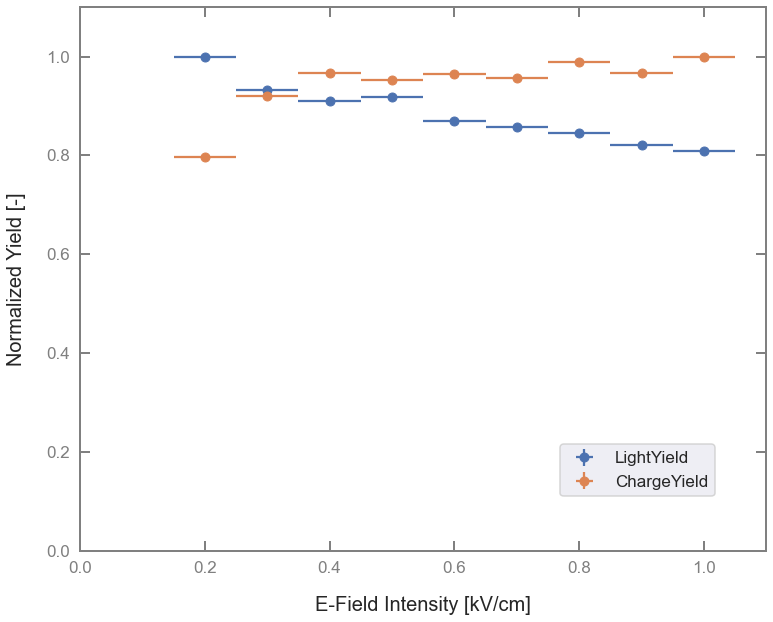

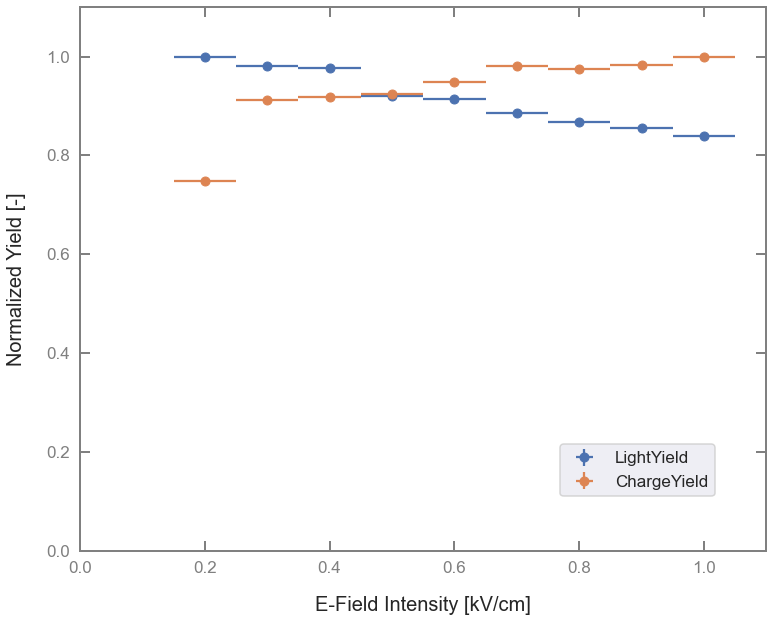

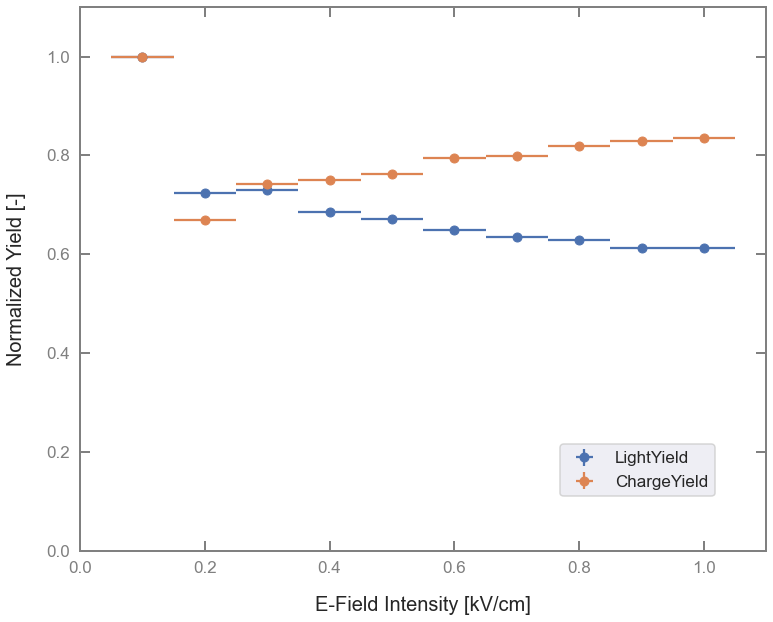

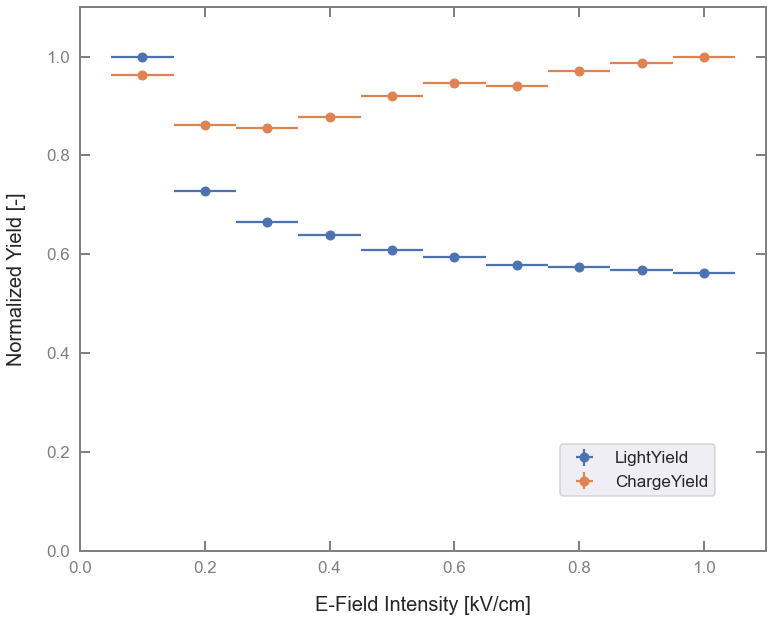

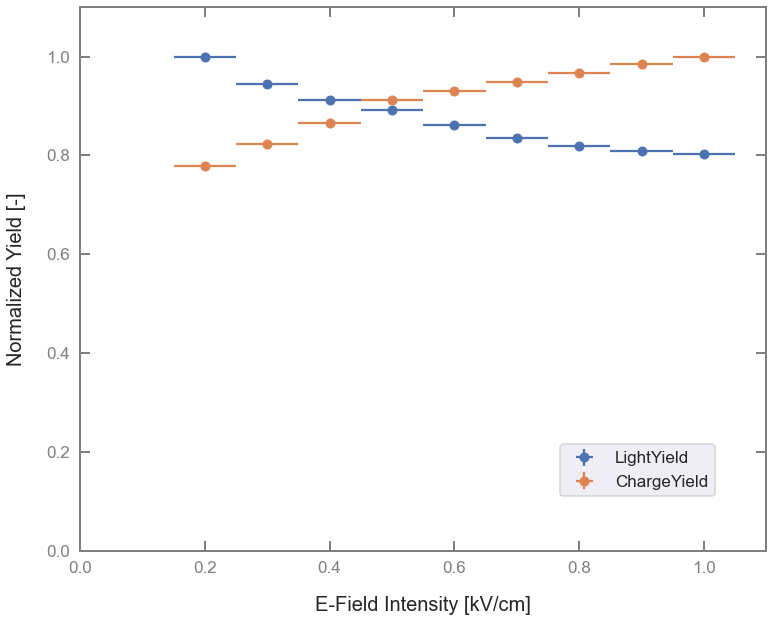

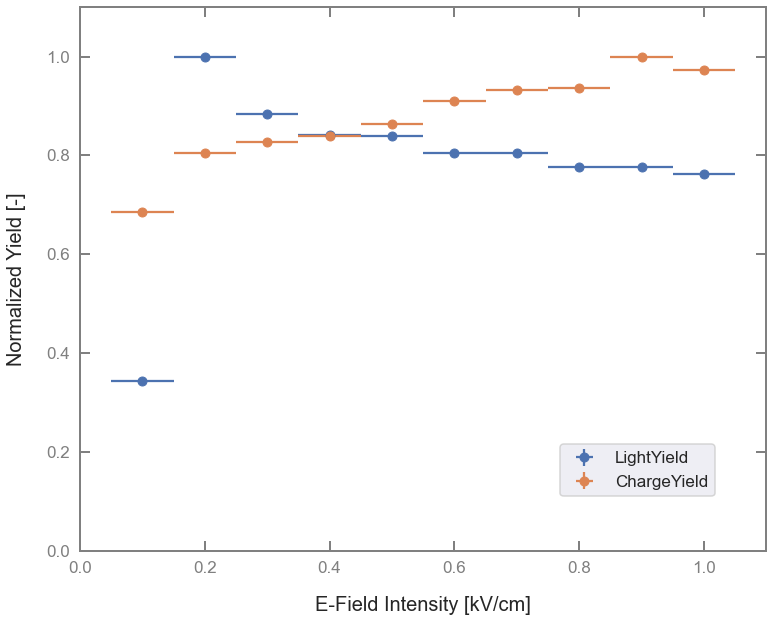

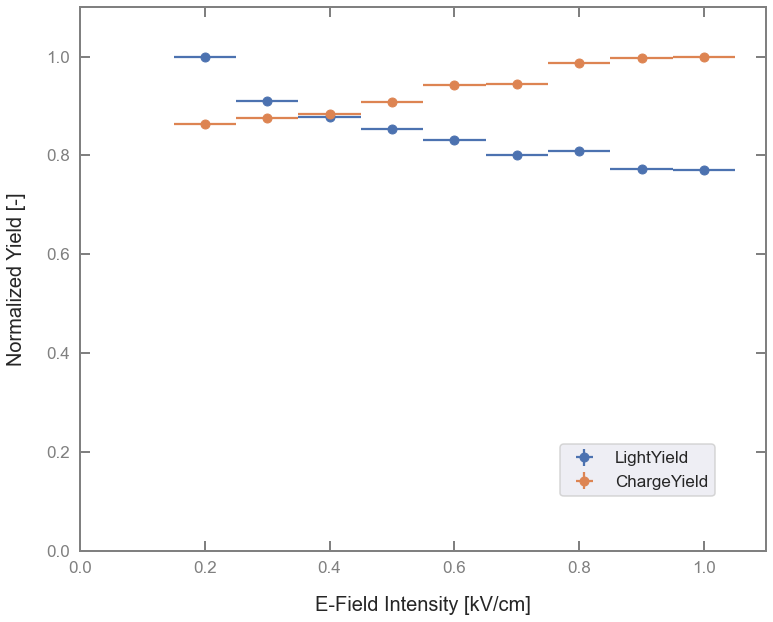

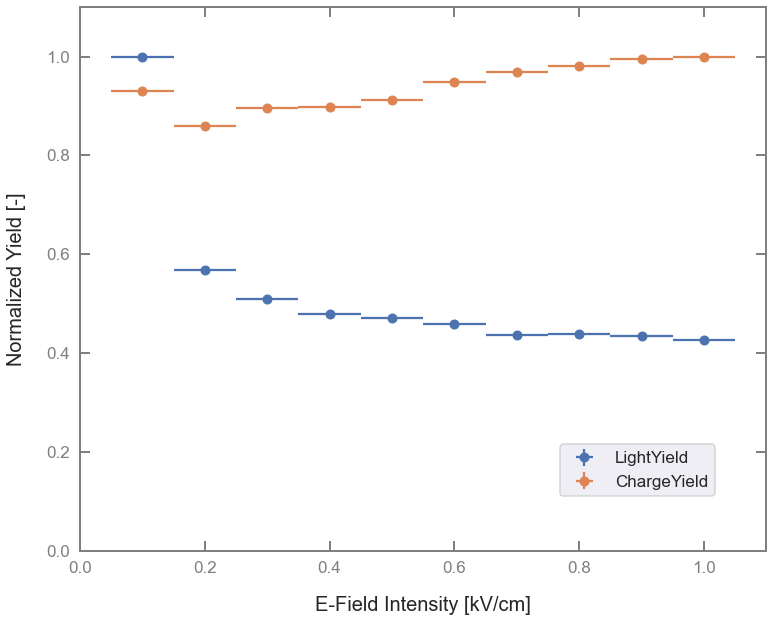

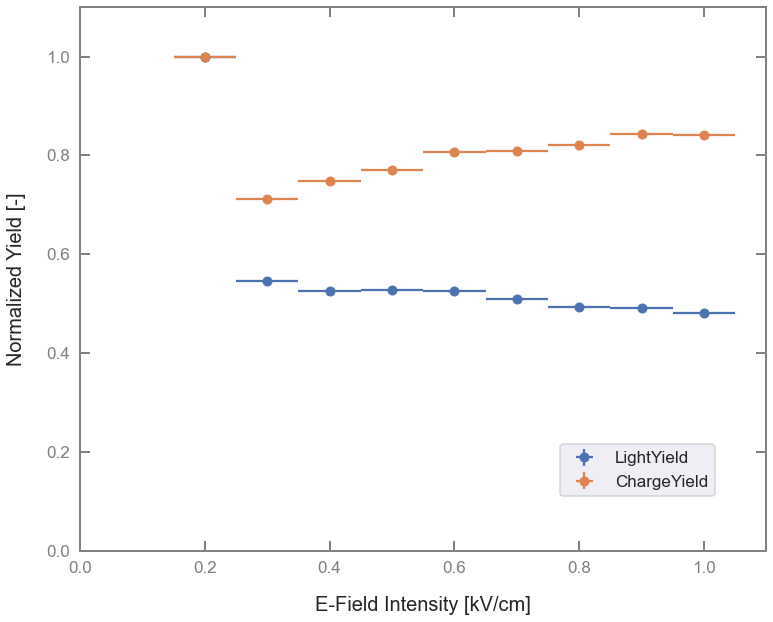

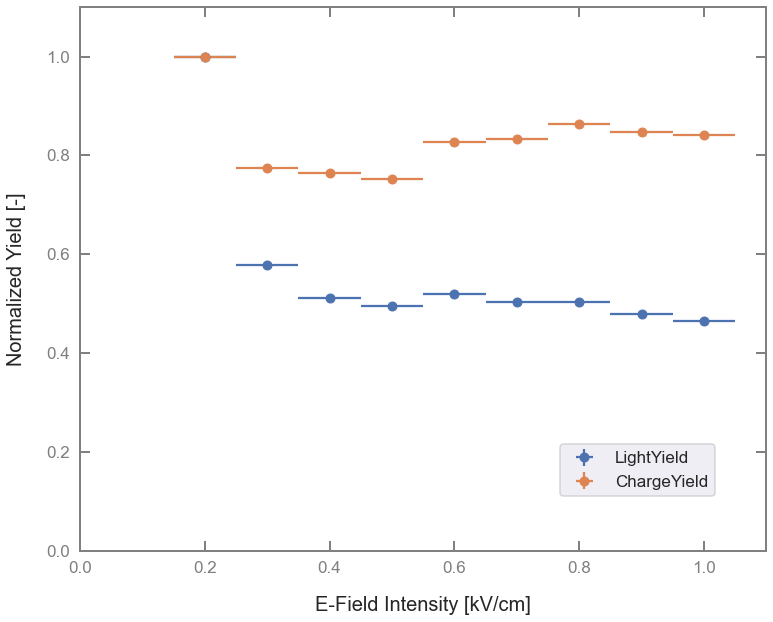

In [37]:
#print(gc_bin_i_list)
#print(ly_mean_bin_i_list)
#print(ly_std_bin_i_list)
#print(cy_mean_bin_i_list)
#print(y_std_bin_i_list)
#print(x_err)

eField_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

LY_list = [] # list containing N (=number of gravicentre_x values) lists
CY_list = [] # list containing N (=number of gravicentre_x values) lists
#LY_err_list = [] # TODO: IS THIS DONE CORRECTLY?
#CY_err_list = [] # TODO: IS THIS DONE CORRECTLY?

for GC_bin in range(10):
    ly     = []
    cy     = []
    #ly_err = []
    #cy_err = []
    for eField in range(10):
        ly.append(ly_mean_bin_i_list[eField][GC_bin])
        cy.append(cy_mean_bin_i_list[eField][GC_bin])
    # Append normalized list
    LY_list.append(ly/np.nanmax(ly))
    CY_list.append(cy/np.nanmax(cy))
    #LY_err_list.append(np.nanstd(ly/np.nanmax(ly))) # TODO: IS THIS DONE CORRECTLY?
    #CY_err_list.append(np.nanstd(cy/np.nanmax(cy))) # TODO: IS THIS DONE CORRECTLY?
    
# Add GC lists of the same eField intensity
#ly_all = []
#cy_all = []
#for eField in range(10):
#    ly_all.append(np.nanmean(LY_list[eField],axis=0))
#    cy_all.append(np.nanmean(CY_list[eField],axis=0))
#print(ly_all)

x_err_list = [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05]
y_err_list = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
#labels_list = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']



# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
x_min = 0.0
x_max = 1.1
y_min = 0.0
y_max = 1.1

for GC_bin in range(len(LY_list)):
    # Size
    seaborn.set(rc={'figure.figsize':(12.3, 10),})
    seaborn.set_context('talk') # or paper

    # Define parameters of the frame
    fig = plt.figure() # plt.figure(figsize=(width,height))
    ax = fig.add_subplot(111)
    ax.patch.set_alpha(0.0)
    ax.spines['bottom'].set_color('0.5') #'black', ...
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_color('0.5')
    ax.spines['top'].set_linewidth(2)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_color('0.5')
    ax.spines['right'].set_linewidth(2)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_color('0.5')
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_visible(True)

    # Ticks, grid and ticks labels
    ax.tick_params(direction='in', length=10, width=2,                  # direction, length and width of the ticks (in, out, inout)
                   colors='0.5',                                       # color of the ticks ('black', '0.5')
                   bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
                   zorder = 10.,                                       # tick and label zorder
                   pad = 10.,                                          # distance between ticks and tick labels
                   labelsize = 17,                                     # size of the tick labels
                   labelright=False, labeltop=False)                   # wether to draw the tick labels on axes
    # Axis limits
    ax.set_xlim((x_min,x_max))
    ax.set_ylim((y_min,y_max))

    # Axis labels
    plt.xlabel('E-Field Intensity [kV/cm]', fontsize=20, labelpad=20)
    plt.ylabel('Normalized Yield [-]', fontsize=20, labelpad=20)

    #if GC_bin in [6]:
    plt.errorbar(eField_list, LY_list[GC_bin], xerr=x_err_list, yerr=y_err_list[GC_bin], fmt='o', label='LightYield') # fmt='-o' # TODO: PROPERLY IMPLEMENT Y_ERRORS/UNCERTAINTIES
    plt.errorbar(eField_list, CY_list[GC_bin], xerr=x_err_list, yerr=y_err_list[GC_bin], fmt='o', label='ChargeYield') # fmt='-o' # TODO: PROPERLY IMPLEMENT Y_ERRORS/UNCERTAINTIES

    #plt.errorbar(eField_list, ly_all, xerr=x_err_list, yerr=y_err_list, fmt='o', label='LightYield') # fmt='-o'
    #plt.errorbar(eField_list, cy_all, xerr=x_err_list, yerr=y_err_list, fmt='o', label='ChargeYield') # fmt='-o'

    # Legend
    plt.legend(loc=[0.7,0.1], prop={'size': 17}) # loc='upper right'

    # Save figure
    save_name = 'plots/NormalizedYield_vs_EField_in_GCbin_' + str(GC_bin)
    plt.savefig(save_name, dpi=400) # bbox_inches='tight'
    #plt.close()
print('Done.')

In [38]:
ly_list = []
cy_list = []
for i in range(10):
    for k in range(10):
        if not (math.isnan(ly_mean_bin_i_list[i][k]) or math.isnan(cy_mean_bin_i_list[i][k])):
            ly_list.append(ly_mean_bin_i_list[i][k])
            cy_list.append(cy_mean_bin_i_list[i][k])
print(ly_list)
print(cy_list)
print(LY_list[0])
print(CY_list[0])
            
x_min    = 0 # np.nanmin(ly_list)
x_max    = 1200 # np.nanmax(ly_list)
y_min    = 0 # np.nanmin(cy_list)
y_max    = 12000 # np.nanmax(cy_list)
n_bins_x = 50
n_bins_y = 50
x_bins = np.linspace(x_min,x_max,n_bins_x)
y_bins = np.linspace(y_min,y_max,n_bins_y)
axis_labels = ['Light Yield [-]','Charge Yield [-]','Entries [-]']
save_name = 'test.png'


#plot_h2([LY_list[0],CY_list[0]],x_bins,y_bins,axis_labels,save_name)
plot_h2([ly_list,cy_list],x_bins,y_bins,axis_labels,save_name)

print('Done.')

[1170.6143798828125, 1115.4857177734375, 208.14549255371094, 782.405517578125, 1148.0804443359375, 983.5781860351562, 848.0180751255581, 811.2001495361328, 666.0458804859835, 605.8535485839843, 495.4009124755859, 443.9773979187012, 556.4278564453125, 480.0044860839844, 1071.0377875434028, 964.2164268493652, 854.5912832706532, 743.0106100406286, 629.4369893196301, 535.2162492214105, 451.37244611467634, 398.2744879784522, 303.78170705396076, 277.4264875139509, 1045.3246270541488, 961.4847683376736, 801.7838658592253, 713.6468631690148, 607.4362429018374, 509.75910974803725, 435.2758668119257, 374.48487735929945, 292.46598118911555, 245.235013961792, 1055.1079850630326, 905.9771921424668, 785.8357251132729, 679.9641034494039, 593.5620986261025, 509.0391792459691, 422.62754762217014, 367.8940631384137, 294.1011336477179, 237.34841341585727, 998.8072861180161, 898.3635264295212, 758.7247472985998, 663.6398191763685, 573.8236560083456, 488.10902910989427, 411.7534290074955, 359.7845809793918

#### Event Display

In [ ]:
# Define which TChain to be used
chain = 0

input_tree = input_tree_list[chain]
n_tracks = input_tree.GetEntries()

print(' n_tracks:          ', input_tree.GetEntries())

plot_folder = str(eField_intensity_list[chain]) + '_kV_per_cm'
print(' plot_folder: ', plot_folder)

# Delete old eventDisplays
os.system('rm -rf plots/' + str(plot_folder) +'/eventDisplays')
os.system('mkdir plots/' + str(plot_folder) +'/eventDisplays')

for track in range(n_tracks):
    if False:
        break
    input_tree.GetEntry(track)
    
    if track%200==0:
        print(' Processing track', track, 'of', n_tracks, 'in total...')

    # Apply Selection Cuts (those should be the same as at the very beginning!)
    # Note: Make a selected_trackID list does not work since there are >1 files in a TChain.
    # Could, e.g., use unique unix_ts or so.
    # For the moment, just apply exactly the same selection cuts as above.
    if input_tree_list[chain].t_track_length < cut_lenght:
        continue
    if input_tree_list[chain].t_event_ntracks > cut_ntracks:
        continue
    if abs(max(input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_end_pos_y)) < cut_throughgoing or\
       abs(min(input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_end_pos_y)) < cut_throughgoing:
        #print(input_tree_list[chain].t_track_start_pos_y)
        #print(input_tree_list[chain].t_track_end_pos_y)
        #print(' ---------------- ')
        continue
    
    hits_x = []
    hits_y = []
    hits_z = []
    hits_q = []

    '''    
    print(' ----------------------------------------- ')
    #print(' t_eventID:        ', input_tree.t_eventID)
    print(' t_trackID:        ', input_tree.t_trackID)
    #print(' t_event_q:        ', input_tree.t_event_q)
    #print(' t_track_q:        ', input_tree.t_track_q)
    #print(' t_event_nhits:    ', input_tree.t_event_nhits)
    print(' t_track_start:    [%.2f , %.2f , %.2f]' %(input_tree.t_track_start_pos_x,input_tree.t_track_start_pos_y,input_tree.t_track_start_pos_z))
    print(' t_track_end:      [%.2f , %.2f , %.2f]' %(input_tree.t_track_end_pos_x,input_tree.t_track_end_pos_y,input_tree.t_track_end_pos_z))
    #print(' max(start_y):     ', max(input_tree.t_track_start_pos_y,input_tree.t_track_end_pos_y))
    #print(' min(start_y):     ', min(input_tree.t_track_start_pos_y,input_tree.t_track_end_pos_y))
    print(' t_track_nhits:    ', input_tree.t_track_nhits)
    #print(' t_track_res_x:    ', input_tree.t_track_residual_x)
    #print(' t_track_res_y:    ', input_tree.t_track_residual_y)
    #print(' t_track_res_z:    ', input_tree.t_track_residual_z)
    #print(' sqrt(res_sum2):   ', np.sqrt(input_tree.t_track_residual_x**2 + input_tree.t_track_residual_y**2 + input_tree.t_track_residual_z**2  ))
    
    #print(' l_LCM_tot :      ', input_tree.l_tlcm1_tot)
    '''
    
    # Loop over all hits
    for hit in range(input_tree.t_track_nhits):
        hits_x.append(input_tree.t_track_hits_x[hit])
        hits_y.append(input_tree.t_track_hits_y[hit])
        hits_z.append(input_tree.t_track_hits_z[hit])
        hits_q.append(input_tree.t_track_hits_q[hit])
    
    
    # Plot 2D projection (onto xy pixel tile)
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    y_min    = pixels_y_min
    y_max    = pixels_y_max
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    #save_name = 'plots/'+str(plot_folder)+'/eventDisplays/trackID_'+str(input_tree.t_trackID)+'_2D.png'
    save_name = 'plots/'+str(plot_folder)+'/eventDisplays/chain_'+str(chain)+'_trackID_'+str(input_tree.t_trackID)+'_2D.png'
    plot_event_2D([hits_x,hits_y,hits_q],x_bins,y_bins,['Coordinate x [mm]','Coordinate y [mm]','Charge Deposition [ke]'],save_name)
    
    
    # Plot 3D event display
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    y_min    = pixels_y_min
    y_max    = pixels_y_max
    z_min    = 0
    z_max    = max(pixels_z_max,np.max(hits_z))
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    n_bins_z = n_pixels_z
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    z_bins = np.linspace(z_min,z_max,n_bins_z)
    #save_name = 'plots/'+str(plot_folder)+'/eventDisplays/trackID_'+str(input_tree.t_trackID)+'_3D.png'
    save_name = 'plots/'+str(plot_folder)+'/eventDisplays/chain_'+str(chain)+'_trackID_'+str(input_tree.t_trackID)+'_3D.png'
    plot_event_3D([hits_x,hits_y,hits_z,hits_q],x_bins,y_bins,z_bins,\
                  ['Coordinate x [mm]','Coordinate y [mm]','Coordinate z [mm]','Charge Deposition [ke]'],save_name)
    '''
    # OLD VERSION
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim((pixels_x_min,pixels_x_max))
    ax.set_ylim((pixels_y_min,pixels_y_max))
    ax.set_zlim((0.,max(3200,np.max(hits_z))))
    img = ax.scatter(hits_x,hits_y,hits_z,c=hits_q,cmap=plt.hot())
    fig.colorbar(img)
    plt.show()
    save_name = 'evDisplay_3D.png'
    plt.savefig(save_name, dpi=400)
    plt.close()
    '''
    
print('Done.')

 n_tracks:           1807
 plot_folder:  1.0_kV_per_cm
 Processing track 0 of 1807 in total...


### Testing Voxelisation algorithm

In [ ]:
'''
# Get all hits in the EVENT (!) and make voxelisation
voxels = np.zeros((n_voxels_x, n_voxels_y, n_voxels_z))

for hit in range(10): #input_tree.t_event_nhits):
    #print(' hit: ', hit, ' \t x: ', input_tree.t_event_hits_x[hit], '\t y: ', input_tree.t_event_hits_y[hit], ' \t z: ', input_tree.t_event_hits_z[hit])

    voxel_x = math.floor((input_tree.t_event_hits_x[hit]+(pitch_x*(n_voxels_x)/2.))/pitch_x)
    voxel_y = math.floor((input_tree.t_event_hits_y[hit]+(pitch_y*(n_voxels_y)/2.))/pitch_y)
    voxel_z = math.floor((input_tree.t_event_hits_z[hit]+(pitch_z*(n_voxels_z)/2.))/pitch_z)

    #print(' voxel_x: ', voxel_x, ' \t voxel_y: ', voxel_y, ' \t voxel_z: ', voxel_z)
    if voxel_x<n_voxels_x and voxel_y<n_voxels_y and voxel_z<n_voxels_z:
        voxels[voxel_x][voxel_y][voxel_z] += input_tree.t_event_hits_q[hit]
    # TODO: make under- and overflow voxel for every coordinate

    h3_event_hits.Fill(input_tree.t_event_hits_x[hit],input_tree.t_event_hits_y[hit],input_tree.t_event_hits_z[hit],input_tree.t_event_hits_q[hit])

for vox_x in range(n_voxels_x):
    vox_x_middle = x_min + (vox_x+0.5)*pitch_x
    for vox_y in range(n_voxels_y):
        vox_y_middle = y_min + (vox_y+0.5)*pitch_y
        for vox_z in range(n_voxels_z):
            vox_z_middle = z_min + (vox_z+0.5)*pitch_z
            if voxels[vox_x][vox_y][vox_z] > 0:
                ntuple.Fill(vox_x_middle,vox_y_middle,vox_z_middle,voxels[vox_x][vox_y][vox_z])
                #h3_event_hits.Fill(vox_x_middle,vox_y_middle,vox_z_middle,voxels[vox_x][vox_y][vox_z])
'''